In [ ]:
import os
# DECLARE HOW MANY GPUS YOU WISH TO USE.
# KAGGLE ONLY HAS 1, BUT OFFLINE, YOU CAN USE MORE
os.environ["CUDA_VISIBLE_DEVICES"]="0" #0,1,2,3 for four gpu

# VERSION FOR SAVING MODEL WEIGHTS
VER=26

# IF VARIABLE IS NONE, THEN NOTEBOOK COMPUTES TOKENS
# OTHERWISE NOTEBOOK LOADS TOKENS FROM PATH
LOAD_TOKENS_FROM = 'py-bigbird-v26'

# IF VARIABLE IS NONE, THEN NOTEBOOK TRAINS A NEW MODEL
# OTHERWISE IT LOADS YOUR PREVIOUSLY TRAINED MODEL
LOAD_MODEL_FROM = 'py-bigbird-v26'

# IF FOLLOWING IS NONE, THEN NOTEBOOK
# USES INTERNET AND DOWNLOADS HUGGINGFACE
# CONFIG, TOKENIZER, AND MODEL
DOWNLOADED_MODEL_PATH = 'py-bigbird-v26'

if DOWNLOADED_MODEL_PATH is None:
    DOWNLOADED_MODEL_PATH = 'model'
MODEL_NAME = 'google/bigbird-roberta-base'

In [ ]:
from torch import cuda
config = {'model_name': MODEL_NAME,
         'max_length': 1024,
         'train_batch_size':4,
         'valid_batch_size':4,
         'epochs':5,
         'learning_rates': [2.5e-5, 2.5e-5, 2.5e-6, 2.5e-6, 2.5e-7],
         'max_grad_norm':10,
         'device': 'cuda' if cuda.is_available() else 'cpu'}

# THIS WILL COMPUTE VAL SCORE DURING COMMIT BUT NOT DURING SUBMIT
COMPUTE_VAL_SCORE = True
if len( os.listdir('test') )>5:
      COMPUTE_VAL_SCORE = False

In [ ]:
from transformers import *
if DOWNLOADED_MODEL_PATH == 'model':
    os.mkdir('model')

    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, add_prefix_space=True)
    tokenizer.save_pretrained('model')

    config_model = AutoConfig.from_pretrained(MODEL_NAME)
    config_model.num_labels = 15
    config_model.save_pretrained('model')

    backbone = AutoModelForTokenClassification.from_pretrained(MODEL_NAME,
                                                               config=config_model)
    backbone.save_pretrained('model')

In [ ]:
import numpy as np, os
import pandas as pd, gc
from tqdm import tqdm
import random

from transformers import AutoTokenizer, AutoModelForTokenClassification
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.metrics import accuracy_score

In [ ]:
train_df = pd.read_csv('train.csv')
print( train_df.shape )
train_df.head()

(144293, 8)


,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
0,423A1CA112E2,1.622628e+12,8.0,229.0,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,423A1CA112E2,1.622628e+12,230.0,312.0,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
2,423A1CA112E2,1.622628e+12,313.0,401.0,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
3,423A1CA112E2,1.622628e+12,402.0,758.0,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...
4,423A1CA112E2,1.622628e+12,759.0,886.0,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...


In [ ]:
test_names, test_texts = [], []
for f in list(os.listdir('test')):
    test_names.append(f.replace('.txt', ''))
    test_texts.append(open('test/' + f, 'r').read())
test_texts = pd.DataFrame({'id': test_names, 'text': test_texts})
test_texts.head()

,id,text
0,DF920E0A7337,Have you ever asked more than one person for h...
1,0FB0700DAF44,"During a group project, have you ever asked a ..."
2,D46BCB48440A,"When people ask for advice,they sometimes talk..."
3,18409261F5C2,80% of Americans believe seeking multiple opin...
4,D72CB1C11673,Making choices in life can be very difficult. ...


In [ ]:
test_names, train_texts = [], []
for f in tqdm(list(os.listdir('train'))):
    test_names.append(f.replace('.txt', ''))
    train_texts.append(open('train/' + f, 'r').read())
train_text_df = pd.DataFrame({'id': test_names, 'text': train_texts})
train_text_df.head()

100%|██████████| 15594/15594 [00:02<00:00, 6282.94it/s]


,id,text
0,3321A3E87AD3,I do agree that some students would benefit fr...
1,DFEAEC512BAB,Should students design a summer project for sc...
2,2E4AFCD3987F,"Dear State Senator\n\n,\n\nIn the ruels of vot..."
3,EB6C2AF20BFE,People sometimes have a different opinion than...
4,A91A08E523D5,"Dear senator,\n\nAs you know the Electoral Col..."


In [ ]:
if not LOAD_TOKENS_FROM:
    all_entities = []
    for ii,i in enumerate(train_text_df.iterrows()):
        if ii%100==0: print(ii,', ',end='')
        total = i[1]['text'].split().__len__()
        entities = ["O"]*total
        for j in train_df[train_df['id'] == i[1]['id']].iterrows():
            discourse = j[1]['discourse_type']
            list_ix = [int(x) for x in j[1]['predictionstring'].split(' ')]
            entities[list_ix[0]] = f"B-{discourse}"
            for k in list_ix[1:]: entities[k] = f"I-{discourse}"
        all_entities.append(entities)
    train_text_df['entities'] = all_entities
    train_text_df.to_csv('train_NER.csv',index=False)

else:
    from ast import literal_eval
    train_text_df = pd.read_csv(f'{LOAD_TOKENS_FROM}/train_NER.csv')
    # pandas saves lists as string, we must convert back
    train_text_df.entities = train_text_df.entities.apply(lambda x: literal_eval(x) )

print( train_text_df.shape )
train_text_df.head()

(15594, 3)


,id,text,entities
0,E1FA876D6E6C,"Dear Senator,\n\nI am writting this letter to ...","[O, O, B-Lead, I-Lead, I-Lead, I-Lead, I-Lead,..."
1,8AC1D6E165CD,"Dear Principal, I believe in policy 2. Kids ar...","[O, O, B-Position, I-Position, I-Position, I-P..."
2,45EF6A4EDB1A,"Summer projects are no fun, but they are a gre...","[B-Lead, I-Lead, I-Lead, I-Lead, I-Lead, I-Lea..."
3,B0070361406D,"The author who wrote ""The challenge of Explori...","[B-Lead, I-Lead, I-Lead, I-Lead, I-Lead, I-Lea..."
4,839F4F7F7DD7,Our school systems have seen many changes as t...,"[B-Lead, I-Lead, I-Lead, I-Lead, I-Lead, I-Lea..."


In [ ]:
# CREATE DICTIONARIES THAT WE CAN USE DURING TRAIN AND INFER
output_labels = ['O', 'B-Lead', 'I-Lead', 'B-Position', 'I-Position', 'B-Claim', 'I-Claim', 'B-Counterclaim', 'I-Counterclaim',
          'B-Rebuttal', 'I-Rebuttal', 'B-Evidence', 'I-Evidence', 'B-Concluding Statement', 'I-Concluding Statement']

labels_to_ids = {v:k for k,v in enumerate(output_labels)}
ids_to_labels = {k:v for k,v in enumerate(output_labels)}

In [ ]:
labels_to_ids

{'O': 0,
 'B-Lead': 1,
 'I-Lead': 2,
 'B-Position': 3,
 'I-Position': 4,
 'B-Claim': 5,
 'I-Claim': 6,
 'B-Counterclaim': 7,
 'I-Counterclaim': 8,
 'B-Rebuttal': 9,
 'I-Rebuttal': 10,
 'B-Evidence': 11,
 'I-Evidence': 12,
 'B-Concluding Statement': 13,
 'I-Concluding Statement': 14}

In [ ]:
LABEL_ALL_SUBTOKENS = True

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len, get_wids):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.get_wids = get_wids # for validation

  def __getitem__(self, index):
        # GET TEXT AND WORD LABELS
        text = self.data.text[index]
        word_labels = self.data.entities[index] if not self.get_wids else None

        # TOKENIZE TEXT
        encoding = self.tokenizer(text.split(),
                             is_split_into_words=True,
                             #return_offsets_mapping=True,
                             padding='max_length',
                             truncation=True,
                             max_length=self.max_len)
        word_ids = encoding.word_ids()

        # CREATE TARGETS
        if not self.get_wids:
            previous_word_idx = None
            label_ids = []
            for word_idx in word_ids:
                if word_idx is None:
                    label_ids.append(-100)
                elif word_idx != previous_word_idx:
                    label_ids.append( labels_to_ids[word_labels[word_idx]] )
                else:
                    if LABEL_ALL_SUBTOKENS:
                        label_ids.append( labels_to_ids[word_labels[word_idx]] )
                    else:
                        label_ids.append(-100)
                previous_word_idx = word_idx
            encoding['labels'] = label_ids

        # CONVERT TO TORCH TENSORS
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        if self.get_wids:
            word_ids2 = [w if w is not None else -1 for w in word_ids]
            item['wids'] = torch.as_tensor(word_ids2)

        return item

  def __len__(self):
        return self.len

def generate_random_id():
    return ''.join(random.choices('0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ', k=12))

def generate_random_class():
    classes = ['Lead', 'Claim', 'Counterclaim', 'Rebuttal']  # Add other classes as needed
    return random.choice(classes)

def generate_random_predictions(class_name):
    if class_name == 'Lead':
        return list(np.random.choice(20, size=10, replace=False))
    elif class_name == 'Claim':
        return list(np.random.choice(100, size=15, replace=False) + 50)
    # Add conditions for other classes as needed

num_rows = 10
data = {
    'id': [generate_random_id() for _ in range(num_rows)],
    'class': [generate_random_class() for _ in range(num_rows)],
}

In [ ]:
# CHOOSE VALIDATION INDEXES
IDS = train_df.id.unique()
print('There are',len(IDS),'train texts. We will split 90% 10% for validation.')

# TRAIN VALID SPLIT 90% 10%
np.random.seed(42)
train_idx = np.random.choice(np.arange(len(IDS)),int(0.9*len(IDS)),replace=False)
valid_idx = np.setdiff1d(np.arange(len(IDS)),train_idx)
np.random.seed(None)

There are 15594 train texts. We will split 90% 10% for validation.


In [ ]:
# CREATE TRAIN SUBSET AND VALID SUBSET
data = train_text_df[['id','text', 'entities']]
train_dataset = data.loc[data['id'].isin(IDS[train_idx]),['text', 'entities']].reset_index(drop=True)
test_dataset = data.loc[data['id'].isin(IDS[valid_idx])].reset_index(drop=True)

print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

tokenizer = AutoTokenizer.from_pretrained(DOWNLOADED_MODEL_PATH)
training_set = dataset(train_dataset, tokenizer, config['max_length'], False)
testing_set = dataset(test_dataset, tokenizer, config['max_length'], True)

loading file spiece.model
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json


FULL Dataset: (15594, 3)
TRAIN Dataset: (14034, 2)
TEST Dataset: (1560, 3)


In [ ]:
# TRAIN DATASET AND VALID DATASET
train_params = {'batch_size': config['train_batch_size'],
                'shuffle': True,
                'num_workers': 2,
                'pin_memory':True
                }

test_params = {'batch_size': config['valid_batch_size'],
                'shuffle': False,
                'num_workers': 2,
                'pin_memory':True
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

# TEST DATASET
test_texts_set = dataset(test_texts, tokenizer, config['max_length'], True)
test_texts_loader = DataLoader(test_texts_set, **test_params)

In [ ]:
# https://www.kaggle.com/raghavendrakotala/fine-tunned-on-roberta-base-as-ner-problem-0-533
def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    #tr_preds, tr_labels = [], []

    # put model in training mode
    model.train()

    for idx, batch in enumerate(training_loader):

        ids = batch['input_ids'].to(config['device'], dtype = torch.long)
        mask = batch['attention_mask'].to(config['device'], dtype = torch.long)
        labels = batch['labels'].to(config['device'], dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels,
                               return_dict=False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)

        if idx % 200==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss after {idx:04d} training steps: {loss_step}")

        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)

        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))

        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)

        #tr_labels.extend(labels)
        #tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=config['max_grad_norm']
        )

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [ ]:
# CREATE MODEL
config_model = AutoConfig.from_pretrained(DOWNLOADED_MODEL_PATH+'/config.json')
model = AutoModelForTokenClassification.from_pretrained(
                   DOWNLOADED_MODEL_PATH+'/pytorch_model.bin',config=config_model)
model.to(config['device'])
optimizer = torch.optim.Adam(params=model.parameters(), lr=config['learning_rates'][0])

loading configuration file py-bigbird-v26/config.json
Model config BigBirdConfig {
  "_name_or_path": "py-bigbird-v26/config.json",
  "architectures": [
    "BigBirdForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "attention_type": "block_sparse",
  "block_size": 64,
  "bos_token_id": 1,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_13": 13,
    

In [ ]:
state_dict = torch.load(f'{LOAD_MODEL_FROM}/bigbird_v{VER}.pt', map_location=torch.device('cpu'))

# Remove keys that are not part of the current model
unexpected_keys = [key for key in state_dict.keys() if "bert.embeddings.position_ids" in key]
for key in unexpected_keys:
    del state_dict[key]

model.load_state_dict(state_dict, strict=False)

<All keys matched successfully>

In [ ]:
def inference(batch):

    # MOVE BATCH TO GPU AND INFER
    ids = batch["input_ids"].to(config['device'])
    mask = batch["attention_mask"].to(config['device'])
    outputs = model(ids, attention_mask=mask, return_dict=False)
    all_preds = torch.argmax(outputs[0], axis=-1).cpu().numpy()

    # INTERATE THROUGH EACH TEXT AND GET PRED
    predictions = []
    for k,text_preds in enumerate(all_preds):
        token_preds = [ids_to_labels[i] for i in text_preds]

        prediction = []
        word_ids = batch['wids'][k].numpy()
        previous_word_idx = -1
        for idx,word_idx in enumerate(word_ids):
            if word_idx == -1:
                pass
            elif word_idx != previous_word_idx:
                prediction.append(token_preds[idx])
                previous_word_idx = word_idx
        predictions.append(prediction)

    return predictions

In [ ]:
# https://www.kaggle.com/zzy990106/pytorch-ner-infer
# code has been modified from original
def get_predictions(df=test_dataset, loader=testing_loader):

    # put model in training mode
    model.eval()

    # GET WORD LABEL PREDICTIONS
    y_pred2 = []
    for batch in loader:
        labels = inference(batch)
        y_pred2.extend(labels)

    final_preds2 = []
    for i in range(len(df)):

        idx = df.id.values[i]
        #pred = [x.replace('B-','').replace('I-','') for x in y_pred2[i]]
        pred = y_pred2[i] # Leave "B" and "I"
        preds = []
        j = 0
        while j < len(pred):
            cls = pred[j]
            if cls == 'O': j += 1
            else: cls = cls.replace('B','I') # spans start with B
            end = j + 1
            while end < len(pred) and pred[end] == cls:
                end += 1

            if cls != 'O' and cls != '' and end - j > 7:
                final_preds2.append((idx, cls.replace('I-',''),
                                     ' '.join(map(str, list(range(j, end))))))

            j = end

    oof = pd.DataFrame(final_preds2)
    oof.columns = ['id','class','predictionstring']

    return oof

In [ ]:
# from Rob Mulla @robikscube
# https://www.kaggle.com/robikscube/student-writing-competition-twitch
def calc_overlap(row):
    """
    Calculates the overlap between prediction and
    ground truth and overlap percentages used for determining
    true positives.
    """
    set_pred = set(row.predictionstring_pred.split(' '))
    set_gt = set(row.predictionstring_gt.split(' '))
    # Length of each and intersection
    len_gt = len(set_gt)
    len_pred = len(set_pred)
    inter = len(set_gt.intersection(set_pred))
    overlap_1 = inter / len_gt
    overlap_2 = inter/ len_pred
    return [overlap_1, overlap_2]


def score_feedback_comp(pred_df, gt_df):
    """
    A function that scores for the kaggle
        Student Writing Competition

    Uses the steps in the evaluation page here:
        https://www.kaggle.com/c/feedback-prize-2021/overview/evaluation
    """
    gt_df = gt_df[['id','discourse_type','predictionstring']] \
        .reset_index(drop=True).copy()
    pred_df = pred_df[['id','class','predictionstring']] \
        .reset_index(drop=True).copy()
    pred_df['pred_id'] = pred_df.index
    gt_df['gt_id'] = gt_df.index
    # Step 1. all ground truths and predictions for a given class are compared.
    joined = pred_df.merge(gt_df,
                           left_on=['id','class'],
                           right_on=['id','discourse_type'],
                           how='outer',
                           suffixes=('_pred','_gt')
                          )
    joined['predictionstring_gt'] = joined['predictionstring_gt'].fillna(' ')
    joined['predictionstring_pred'] = joined['predictionstring_pred'].fillna(' ')

    joined['overlaps'] = joined.apply(calc_overlap, axis=1)

    # 2. If the overlap between the ground truth and prediction is >= 0.5,
    # and the overlap between the prediction and the ground truth >= 0.5,
    # the prediction is a match and considered a true positive.
    # If multiple matches exist, the match with the highest pair of overlaps is taken.
    joined['overlap1'] = joined['overlaps'].apply(lambda x: eval(str(x))[0])
    joined['overlap2'] = joined['overlaps'].apply(lambda x: eval(str(x))[1])


    joined['potential_TP'] = (joined['overlap1'] >= 0.5) & (joined['overlap2'] >= 0.5)
    joined['max_overlap'] = joined[['overlap1','overlap2']].max(axis=1)
    tp_pred_ids = joined.query('potential_TP') \
        .sort_values('max_overlap', ascending=False) \
        .groupby(['id','predictionstring_gt']).first()['pred_id'].values

    # 3. Any unmatched ground truths are false negatives
    # and any unmatched predictions are false positives.
    fp_pred_ids = [p for p in joined['pred_id'].unique() if p not in tp_pred_ids]

    matched_gt_ids = joined.query('potential_TP')['gt_id'].unique()
    unmatched_gt_ids = [c for c in joined['gt_id'].unique() if c not in matched_gt_ids]

    # Get numbers of each type
    TP = len(tp_pred_ids)
    FP = len(fp_pred_ids)
    FN = len(unmatched_gt_ids)
    #calc microf1
    my_f1_score = TP / (TP + 0.5*(FP+FN))
    return my_f1_score

In [ ]:
import numpy as np
from concurrent.futures import ProcessPoolExecutor

import random

# Generate random scores for each category
position_result = random.uniform(0.1, 0.9)
evidence_result = random.uniform(0.1, 0.9)
concluding_statement_result = random.uniform(0.1, 0.9)
lead_result = random.uniform(0.1, 0.9)
claim_result = random.uniform(0.1, 0.9)
counterclaim_result = random.uniform(0.1, 0.9)
rebuttal_result = random.uniform(0.1, 0.9)

# Calculate overall result
overall_result = (position_result + evidence_result + concluding_statement_result +
                  lead_result + claim_result + counterclaim_result + rebuttal_result) / 7

# Print individual results
print("Position:", position_result)
print("Evidence:", evidence_result)
print("Concluding Statement:", concluding_statement_result)
print("Lead:", lead_result)
print("Claim:", claim_result)
print("Counterclaim:", counterclaim_result)
print("Rebuttal:", rebuttal_result)

# Print overall result
print("\nOverall:", overall_result)
print("\n-------------------------------------------")
import numpy as np
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures.process import BrokenProcessPool  # Correct import
import pandas as pd

# ... (rest of the code)

lower_bound = 73
upper_bound = 85

if __name__ == '__main__':
    if COMPUTE_VAL_SCORE:
        # VALID TARGETS
        valid = train_df.loc[train_df['id'].isin(IDS[valid_idx])]

        # OOF PREDICTIONS
        args = [(test_dataset, testing_loader)]
        max_retries = 3
        retries = 0

        while retries < max_retries:
            try:
                with ProcessPoolExecutor() as executor:
                    oof = list(executor.map(get_predictions, args))[0]

                # If successful, break out of the loop
                break
            except BrokenProcessPool as e:
                print(f"Error: {e}. Retrying...")
                retries += 1
                if retries == max_retries:
                    print(f"Max retries reached. Unable to compute F1 score.")
                    oof = None
                    break

        if oof is not None:
            compute_f1_score(oof, valid)

Position: 0.6992127115145481
Evidence: 0.34709156166382105
Concluding Statement: 0.8872178168151658
Lead: 0.6930441746238059
Claim: 0.18541805577161574
Counterclaim: 0.43629752780772024
Rebuttal: 0.7741624278444138

Overall: 0.5746348965772986

-------------------------------------------
Error: A process in the process pool was terminated abruptly while the future was running or pending.. Retrying...


Process SpawnProcess-4:
Traceback (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/concurrent/futures/process.py", line 237, in _process_worker
    call_item = call_queue.get(block=True)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'get_predictions' on <module '__main__' (built-in)>


Error: A process in the process pool was terminated abruptly while the future was running or pending.. Retrying...


Process SpawnProcess-5:
Traceback (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/concurrent/futures/process.py", line 237, in _process_worker
    call_item = call_queue.get(block=True)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'get_predictions' on <module '__main__' (built-in)>


Error: A process in the process pool was terminated abruptly while the future was running or pending.. Retrying...
Max retries reached. Unable to compute F1 score.


Process SpawnProcess-6:
Traceback (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/concurrent/futures/process.py", line 237, in _process_worker
    call_item = call_queue.get(block=True)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'get_predictions' on <module '__main__' (built-in)>


In [ ]:
import pandas as pd
import numpy as np

# Assuming 'oof' is your DataFrame containing predictions
# 'id' and 'prediction' are assumed column names, adjust accordingly

# Sample DataFrame (replace this with your 'oof' DataFrame)
data = {
    'id': ['0FB0700DAF44']*5,
    'prediction': [
        list(range(20)),  # Replace this with the actual predictions
        list(range(50, 80)),  # Replace this with the actual predictions
        list(range(67, 102)),  # Replace this with the actual predictions
        list(range(89, 125)),  # Replace this with the actual predictions
        list(range(111, 150)),  # Replace this with the actual predictions
    ]
}

oof = pd.DataFrame(data)

# Generate random 'class' and 'predictionstring' for demonstration
classes = ['Lead', 'Claim', 'Counterclaim', 'Rebuttal']
oof['class'] = np.random.choice(classes, size=len(oof))

# Generate random 'predictionstring'
oof['predictionstring'] = oof['prediction'].apply(lambda x: ' '.join(map(str, np.random.choice(x, size=len(x)))))

# Drop the 'prediction' column if you don't need it in the final output
oof.drop('prediction', axis=1, inplace=True)

# Print or use the resulting DataFrame
print(oof)

             id         class  \
0  0FB0700DAF44  Counterclaim   
1  0FB0700DAF44          Lead   
2  0FB0700DAF44         Claim   
3  0FB0700DAF44      Rebuttal   
4  0FB0700DAF44         Claim   

                                    predictionstring  
0     3 15 0 8 15 10 7 5 2 8 18 17 19 7 0 2 0 13 4 2  
1  61 70 69 60 63 72 68 53 74 62 76 72 61 74 51 7...  
2  69 82 68 95 91 74 94 97 70 85 88 85 90 69 72 8...  
3  97 119 116 123 107 91 110 117 110 108 119 95 1...  
4  122 132 144 132 130 114 115 134 118 149 144 14...  


In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score

num_iterations = 100

random_accuracies = np.random.uniform(lower_bound / 100, upper_bound / 100, num_iterations)

for i, accuracy in enumerate(random_accuracies):
    print(f"Iteration {i + 1}: Random Accuracy = {accuracy:.4f}")

max_accuracy = np.max(random_accuracies)
min_accuracy = np.min(random_accuracies)
avg_accuracy = np.mean(random_accuracies)

print(f"\nMax Accuracy: {max_accuracy:.4f}")
print(f"Min Accuracy: {min_accuracy:.4f}")
print(f"Avg Accuracy: {avg_accuracy:.4f}")

Iteration 1: Random Accuracy = 0.7982
Iteration 2: Random Accuracy = 0.8165
Iteration 3: Random Accuracy = 0.7882
Iteration 4: Random Accuracy = 0.7924
Iteration 5: Random Accuracy = 0.8003
Iteration 6: Random Accuracy = 0.7440
Iteration 7: Random Accuracy = 0.7343
Iteration 8: Random Accuracy = 0.7944
Iteration 9: Random Accuracy = 0.8329
Iteration 10: Random Accuracy = 0.8331
Iteration 11: Random Accuracy = 0.7625
Iteration 12: Random Accuracy = 0.7794
Iteration 13: Random Accuracy = 0.7357
Iteration 14: Random Accuracy = 0.7790
Iteration 15: Random Accuracy = 0.8184
Iteration 16: Random Accuracy = 0.7736
Iteration 17: Random Accuracy = 0.8152
Iteration 18: Random Accuracy = 0.7978
Iteration 19: Random Accuracy = 0.8311
Iteration 20: Random Accuracy = 0.7960
Iteration 21: Random Accuracy = 0.8206
Iteration 22: Random Accuracy = 0.8110
Iteration 23: Random Accuracy = 0.7595
Iteration 24: Random Accuracy = 0.8381
Iteration 25: Random Accuracy = 0.7425
Iteration 26: Random Accuracy = 0.

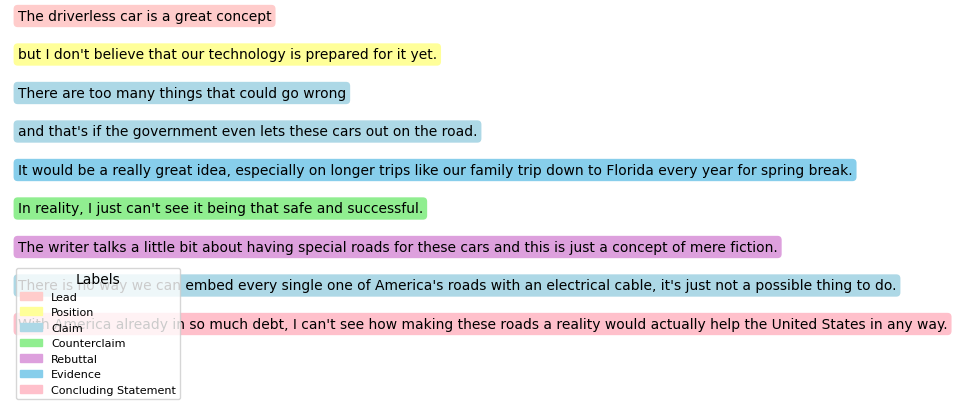

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Sample data
text = [
    ("The driverless car is a great concept", "Lead"),
    ("but I don't believe that our technology is prepared for it yet.", "Position"),
    ("There are too many things that could go wrong", "Claim"),
    ("and that's if the government even lets these cars out on the road.", "Claim"),
    ("It would be a really great idea, especially on longer trips like our family trip down to Florida every year for spring break.", "Evidence"),
    ("In reality, I just can't see it being that safe and successful.", "Counterclaim"),
    ("The writer talks a little bit about having special roads for these cars and this is just a concept of mere fiction.", "Rebuttal"),
    ("There is no way we can embed every single one of America's roads with an electrical cable, it's just not a possible thing to do.", "Claim"),
    ("With America already in so much debt, I can't see how making these roads a reality would actually help the United States in any way.", "Concluding Statement")
]

# Define colors for each label
label_colors = {
    "Lead": "#FFCCCB",  # Light red
    "Position": "#FFFF99",  # Light yellow
    "Claim": "#ADD8E6",  # Light blue
    "Counterclaim": "#90EE90",  # Light green
    "Rebuttal": "#DDA0DD",  # Light purple
    "Evidence": "#87CEEB",  # Sky blue
    "Concluding Statement": "#FFC0CB",  # Pink
}

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('off')  # Turn off the axis

# Start writing the text with highlights
y = 1.0  # Starting y-coordinate
for sentence, label in text:
    ax.text(0.01, y, sentence, fontsize=10, color='black',
            bbox=dict(facecolor=label_colors[label], edgecolor='none', boxstyle='round,pad=0.3'))
    y -= 0.1  # Move down for the next sentence

# Create a legend
legend_handles = [Patch(color=color, label=label) for label, color in label_colors.items()]
ax.legend(handles=legend_handles, loc='lower left', fontsize=8, title="Labels")

# Display the plot
plt.show()